In [229]:

import dgl
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import networkx as nx

In [230]:
node_count =5
with open ('/Users/wuyou/Downloads/edge_list.pickle','rb') as file:
    edge_list = pickle.load (file)
edge_list

[('0', '8'),
 ('1', '17'),
 ('24', '31'),
 ('13', '33'),
 ('0', '1'),
 ('2', '8'),
 ('0', '19'),
 ('25', '31'),
 ('14', '33'),
 ('0', '2'),
 ('2', '9'),
 ('1', '19'),
 ('28', '31'),
 ('15', '33'),
 ('1', '2'),
 ('0', '10'),
 ('0', '21'),
 ('2', '32'),
 ('18', '33'),
 ('0', '3'),
 ('4', '10'),
 ('1', '21'),
 ('8', '32'),
 ('19', '33'),
 ('1', '3'),
 ('5', '10'),
 ('23', '25'),
 ('14', '32'),
 ('20', '33'),
 ('2', '3'),
 ('0', '11'),
 ('24', '25'),
 ('15', '32'),
 ('22', '33'),
 ('0', '4'),
 ('0', '12'),
 ('2', '27'),
 ('18', '32'),
 ('23', '33'),
 ('0', '5'),
 ('3', '12'),
 ('23', '27'),
 ('20', '32'),
 ('26', '33'),
 ('0', '6'),
 ('0', '13'),
 ('24', '27'),
 ('22', '32'),
 ('27', '33'),
 ('4', '6'),
 ('1', '13'),
 ('2', '28'),
 ('23', '32'),
 ('28', '33'),
 ('5', '6'),
 ('2', '13'),
 ('23', '29'),
 ('29', '32'),
 ('29', '33'),
 ('0', '7'),
 ('3', '13'),
 ('26', '29'),
 ('30', '32'),
 ('30', '33'),
 ('1', '7'),
 ('5', '16'),
 ('1', '30'),
 ('31', '32'),
 ('31', '33'),
 ('2', '7'),
 ('6'

In [231]:
def build_karate_club_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    edges = [(a,b) for a,b in edges if int(a)<node_count and int(b)<node_count]
    
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    print(g.edges())
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    print(g.edges())
    return g

In [232]:
G = build_karate_club_graph(edge_list)

(tensor([0, 0, 1, 0, 1, 2, 0]), tensor([1, 2, 2, 3, 3, 3, 4]))
(tensor([0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 3, 3, 3, 4]), tensor([1, 2, 2, 3, 3, 3, 4, 0, 0, 1, 0, 1, 2, 0]))


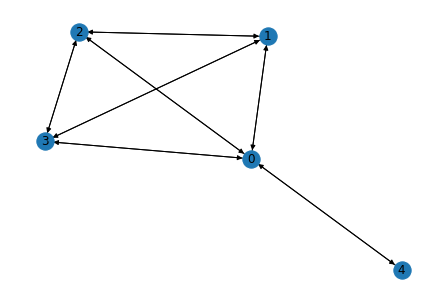

In [233]:
nx_G = G.to_networkx()

pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G,pos, with_labels = True)

In [234]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    return {'msg' : edges.src['h']}
    
def gcn_reduce(nodes):
    return{'h': torch.sum(nodes.mailbox['msg'],dim=1)}
    print('nodes.mailbox', nodes.mailbox)

class GCN_Layer(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCN_Layer,self).__init__()
        self.linear = nn.Linear(in_feats,out_feats)

    def forward (self,g,inputs):
        g.ndata['h'] = inputs
        print("g.ndata", g.ndata)
        print("g.edges before send",g.edges())

        g.send(g.edges(),gcn_message)
        print("g.edges after send", g.edges())
        g.recv(g.nodes(),gcn_reduce)
        print("g.nodes(),g.ndata after revb", g.nodes(),g.ndata)

        h = g.ndata.pop('h')    
        print("after pop,h ", h)

        h= self.linear(h)
        print("after linear", h)
        
        return h
        

In [235]:
class GCN(nn.Module):
    def __init__ (self, in_feats, hidden_feats, num_classes):
        super(GCN,self).__init__()
        self.gcn1 = GCN_Layer(in_feats,hidden_feats)
        self.gcn2 = GCN_Layer(hidden_feats,num_classes)
        self.softmax = nn.Softmax()

    def forward (self,g,inputs):
        print("strating point",inputs)
        h = self.gcn1(g,inputs)
        
        h = torch.relu(h)
        print("after relu hidden layer 1",h.shape, h)

        h = self.gcn2(g, h)
        print("hidden layer 2 before softmax" , h)
        h = self.softmax(h)

        print("after softmax" , h)

        return h


In [236]:
net = GCN(node_count,4,2)
inputs = torch.eye(node_count)
labeled_nodes = torch.tensor([0,node_count-1])
labels = torch.tensor([0,1])


In [237]:
optimizer = torch.optim.Adam(net.parameters(),lr = 0.1)

all_preds = []
epochs =1
losses = []

for epoch in range(epochs):

    preds = net(G,inputs)
    all_preds.append(preds)
    loss = F.cross_entropy(preds[labeled_nodes],labels)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print(f"Epoch { epoch} | Loss: {loss.item()}")


strating point tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
g.ndata {'h': tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])}
g.edges before send (tensor([0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 3, 3, 3, 4]), tensor([1, 2, 2, 3, 3, 3, 4, 0, 0, 1, 0, 1, 2, 0]))
g.edges after send (tensor([0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 3, 3, 3, 4]), tensor([1, 2, 2, 3, 3, 3, 4, 0, 0, 1, 0, 1, 2, 0]))
g.nodes(),g.ndata after revb tensor([0, 1, 2, 3, 4]) {'h': tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])}
after pop,h  tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])
after linear tensor([[ 0.1628, -0.1070, -0.3

In [238]:
losses

[0.7518528699874878]

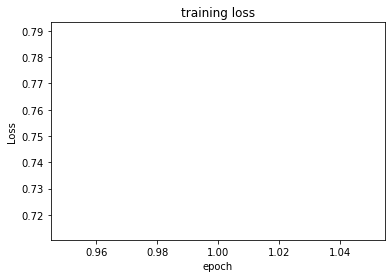

In [244]:
plt.plot(range(1, epochs+1), losses, color='r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('training loss')
plt.show()


In [240]:
lastone = all_preds[0].detach().numpy()
lastone

array([[0.29746497, 0.70253503],
       [0.34643278, 0.6535673 ],
       [0.30619904, 0.69380105],
       [0.3457542 , 0.6542458 ],
       [0.38827673, 0.6117233 ]], dtype=float32)

In [241]:
predicted_class = np.argmax (lastone,axis= -1 )
predicted_class

array([1, 1, 1, 1, 1])

In [242]:
color = np.where(predicted_class==0, 'c', 'r')

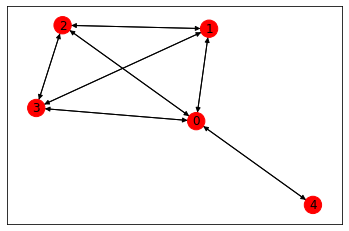

In [243]:
nx.draw_networkx(nx_G, pos, node_color=color, with_labels=True)